# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
# Import the class
from xopt import Xopt

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

import multiprocessing
N_CPUS=multiprocessing.cpu_count()//2
N_CPUS



5

In [2]:
!mkdir -p temp

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """
xopt:
  asynch: True
  max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0.5.0+244.gb8037f4.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [4]:
%%timeit
# Check that the averate time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = .1)

110 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%time
X.run()

CPU times: user 9.24 s, sys: 106 ms, total: 9.34 s
Wall time: 1min 55s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    
len(X.data)

CPU times: user 6.62 ms, sys: 8.91 ms, total: 15.5 ms
Wall time: 19.1 ms


0

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time

X = Xopt(YAML)

with ThreadPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 4.43 s, sys: 109 ms, total: 4.54 s
Wall time: 25.1 s


1001

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.yaml('test.yaml')
!cat test.yaml

xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [11]:
%%time
!mpirun -n {N_CPUS} python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2)
Parallel execution with 5 workers
Initializing Xopt object
Initializing generator cnsga,
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2
Initializing Xopt object
Xopt object initialized
Enabling async mode

            Xopt
________________________________
Version: 0.5.0+244.gb8037f4.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  co

In [12]:
!tail xopt.log

2022-07-01T20:25:41-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T20:25:41-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T20:25:41-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T20:25:41-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T20:25:41-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T20:25:41-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T20:25:41-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T20:25:41-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T20:25:41-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T20:25:41-0700 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51729,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:51756,Total threads: 2
Dashboard: http://127.0.0.1:51757/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:51736,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()

CPU times: user 5.35 s, sys: 759 ms, total: 6.11 s
Wall time: 26.6 s


# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
5,2.534560,0.958003,dummy_constant,2.534560,2.534560,0.958003,6.254060,4.349200,"[1, 2, 3]",False,
1,1.726435,2.005535,dummy_constant,1.726435,1.726435,2.005535,5.965986,3.770777,"[1, 2, 3]",False,
2,0.649429,3.138814,dummy_constant,0.649429,0.649429,3.138814,9.373159,6.985668,"[1, 2, 3]",False,
3,0.944018,0.634146,dummy_constant,0.944018,0.944018,0.634146,0.393233,0.215147,"[1, 2, 3]",False,
4,2.130957,1.812507,dummy_constant,2.130957,2.130957,1.812507,6.798378,4.382697,"[1, 2, 3]",False,
...,...,...,...,...,...,...,...,...,...,...,...
996,0.490667,1.008328,dummy_constant,NaN,0.490667,1.008328,0.200368,0.258484,"[1, 2, 3]",False,
998,0.887096,0.832257,dummy_constant,NaN,0.887096,0.832257,0.392325,0.260238,"[1, 2, 3]",False,
999,0.045609,1.009937,dummy_constant,NaN,0.045609,1.009937,-0.052991,0.466506,"[1, 2, 3]",False,
1000,0.622982,0.757516,dummy_constant,NaN,0.622982,0.757516,-0.039708,0.081439,"[1, 2, 3]",False,


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str,feasible_c1,feasible_c2,feasible
3,0.944018,0.634146,dummy_constant,0.944018,0.944018,0.634146,0.393233,0.215147,"[1, 2, 3]",False,,True,True,True
36,0.975608,1.010900,dummy_constant,0.975608,0.975608,1.010900,0.877741,0.487222,"[1, 2, 3]",False,,True,True,True
44,0.419929,1.068103,dummy_constant,0.419929,0.419929,1.068103,0.221353,0.329152,"[1, 2, 3]",False,,True,True,True
42,1.081027,0.542694,dummy_constant,1.081027,1.081027,0.542694,0.423292,0.339415,"[1, 2, 3]",False,,True,True,True
53,0.756893,0.849138,dummy_constant,0.756893,0.756893,0.849138,0.233180,0.187892,"[1, 2, 3]",False,,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0.802580,0.939962,dummy_constant,NaN,0.802580,0.939962,0.496970,0.285121,"[1, 2, 3]",False,,True,True,True
993,0.719661,0.804975,dummy_constant,NaN,0.719661,0.804975,0.103297,0.141261,"[1, 2, 3]",False,,True,True,True
996,0.490667,1.008328,dummy_constant,NaN,0.490667,1.008328,0.200368,0.258484,"[1, 2, 3]",False,,True,True,True
998,0.887096,0.832257,dummy_constant,NaN,0.887096,0.832257,0.392325,0.260238,"[1, 2, 3]",False,,True,True,True


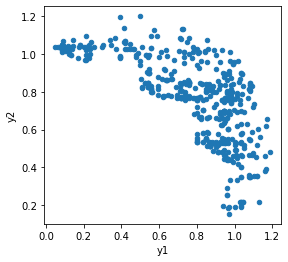

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

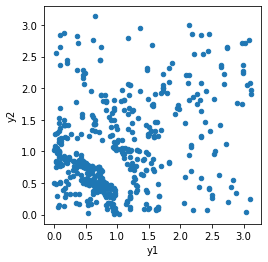

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

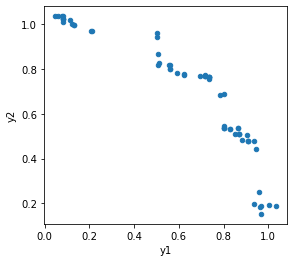

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

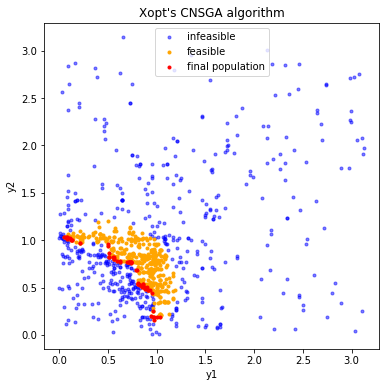

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml